In [1]:
import os

repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")

os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn 
import sys
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from scipy.stats import spearmanr, mode

import geopandas as gpd
import rasterio
import zarr

import gc

import warnings

from mosaiks.utils.imports import *

from mosaiks.utils.io import weighted_groupby
from affine import Affine

import cartopy.crs as ccrs
# Key prediction functions are here
import matplotlib.patheffects as pe
import cartopy.feature as cf

from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point

# Super zooms on newly produced data

Like the global maps, replicating these visualizations requires a large number of shapefiles that are not in the GitHub repo.

In [2]:
raster_outpath = (data_dir + "preds/"
           "hdi_raster_predictions.tif")

In [3]:
vmin,vmax = (0.35, 0.84) # More condensed than Fig3

In [4]:
roads = gpd.read_file(data_dir + "raw/basemap_data/stanford-vs175mk0273-geojson.json")
## Roads data from this source: https://maps.princeton.edu/catalog/stanford-vs175mk0273

cities = pd.read_csv(data_dir + "raw/basemap_data/World_Cities.csv")
## Cities data from this source: https://hub.arcgis.com/datasets/esri::world-cities/explore?location=2.820021%2C1.535162%2C2.42



In [36]:
countries = pd.read_pickle(data_dir +"int/GDL_HDI/HDI_ADM0_dissolved_shapefile.p")
adm1 = pd.read_pickle(data_dir + "int/GDL_HDI/HDI_ADM1_shapefile_clean.p" )
adm2 = gpd.read_file(data_dir + "raw/geoBoundaries/geoBoundariesCGAZ_ADM2.geojson")
adm2_preds = pd.read_pickle(data_dir+"preds/hdi_preds_at_adm2.p")

raw_countries = pd.read_pickle(data_dir + "/int/" +
                    "GDL_HDI/HDI_indicators_and_indices_clean.p").groupby("ISO_Code")["country"].first()
countries = countries.merge(raw_countries, left_index=True, right_index=True)

In [39]:
# drop_list = ["NGA","BGD"]

In [40]:
# shapes = list(countries.drop(drop_list)["geometry"])

In [41]:
#new = list((adm2[adm2["shapeGroup"].isin(drop_list)].dissolve("shapeGroup")["geometry"])[drop_list])

In [42]:
#countries = gpd.GeoDataFrame({"geometry": shapes+new,
#                               "country":countries.loc[list(countries.drop(drop_list).index) + drop_list,"country"]}, 
#                              index= list(countries.drop(drop_list).index) + drop_list)

In [43]:
arr = rasterio.open(raster_outpath).read(1)

In [44]:
print("n_obs raster:", (~np.isnan(arr)).sum())

n_obs raster: 807651


In [45]:
print("n_obs adm2:", len(adm2_preds.dropna(subset=["adjusted_preds"])))

n_obs adm2: 61530


In [46]:
def make_superzoom(left_bound, right_bound, top_bound, lower_bound, savepath=None):
    if savepath:
        rasterized=True
    else:
        rasterized=False
    
    ### Calculations for scalebar
    points = gpd.GeoSeries([Point(-73.5, (top_bound+lower_bound)/2), Point(-74.5, (top_bound+lower_bound)/2)], crs=4326)  # Geographic WGS 84 - degrees
    points = points.to_crs(32619) # Projected WGS 84 - meters
    distance_meters = points[0].distance(points[1])
    
    fig, ax = plt.subplots(1,2, figsize=(20,13), subplot_kw={"projection" : ccrs.PlateCarree()})

    countries.plot(ax=ax[1], color="lightgrey", zorder=0, rasterized=rasterized,linewidth=4)

    with rasterio.open(raster_outpath) as src:
        rst = src.read(1, window= rasterio.windows.from_bounds(left_bound, lower_bound, right_bound, top_bound, src.transform))
        print(rst.shape)
        print(rst)
    a = ax[1].imshow(rst, interpolation=None,#"nearest",
                  extent = (left_bound,right_bound,lower_bound,top_bound),
                  cmap="plasma", 
                  vmin=vmin, vmax=vmax,
                  zorder=1,
                  )

    ax[1].set_xlim(left_bound, right_bound)
    ax[1].set_ylim(lower_bound, top_bound)


    # Country labels
    for i, row in countries.iterrows():
        x = row["geometry"].centroid.x
        y = row["geometry"].centroid.y
        country = row["country"]
        y_adj = 0
        x_adj= 0
        
        if country == "Bangladesh":
            y_adj= 1
        if country == "Nigeria":
            y_adj= -1
        if country== "Benin":
            y_adj = - 1
            x_adj = -1
        if country == "Togo":
            y_adj = -1.4
            X_adj = -.3
        if country== "Ghana":
            x_adj = -.8
        if country == "Equatorial Guinea":
            continue
        if country == "Dominican Republic":
            x_adj = -.3
        

        if (left_bound < x < right_bound) and (lower_bound < y < top_bound):
            print(row["country"])
            ax[1].text(x+x_adj, y+y_adj, country,
               fontweight = "semibold", size=18, zorder=6, color="grey",
                   path_effects=[pe.withStroke(linewidth=2, foreground="white")])

        
    ## City labels
    for i, row in cities.iterrows():
        if row["POP_RANK"] > 3 or row["POP_RANK"]==0: # Only include cities with pop rank of 1, 2, or 3
            continue
        x = row["X"]
        y = row["Y"]
        city = row["CITY_NAME"]
        if city == "Yaounde":
            continue
        if city == "Cotonou":
            continue
        if city == "Enugu":
            continue
        
        if (left_bound < x < right_bound) and (lower_bound < y < top_bound):
            ax[1].text(x+.015, y+.015, city,
              size=13, zorder=5, color="black",fontweight = "semibold",
                   path_effects=[pe.withStroke(linewidth=2, foreground="white")])

            ax[1].scatter(x,y, s=12, color="black", zorder=4,
                       edgecolor='white', linewidth=1)



    ## Adm bounds
    ax[1].add_feature(cf.BORDERS,linewidth=2.2, zorder=2, 
                    rasterized=False, 
               color="black", alpha=.65)
    
    ax[1].add_feature(cf.COASTLINE,linewidth=2.2, zorder=2, 
                rasterized=False, 
           color="black", alpha=.65)
    
    adm1.exterior.plot(ax = ax[1], linewidth=1.2, zorder=2, 
                       rasterized=rasterized, color="black", alpha=.60)
    adm2.boundary.plot(ax = ax[1], linewidth=0.3, zorder=2, 
                       rasterized=rasterized, color="black", alpha=.55)

    ## Roads
    roads.plot(ax=ax[1], marker = "-", color="white", linewidth=1.5,
               zorder=3, alpha=.8, rasterized=rasterized)

    roads.plot(ax=ax[1], linestyle = "--", color="black", linewidth=1.5,
               zorder=3, 
                   alpha=.8, rasterized=rasterized)

    ax[1].get_yaxis().set_visible(False)
    ax[1].get_xaxis().set_visible(False)
    ax[1].add_artist(ScaleBar(distance_meters, location='lower left'))
    
################### ADM2 Panel

    countries.plot(ax=ax[0], color="lightgrey", zorder=0, rasterized=rasterized,linewidth=4)

    adm2_preds.plot(ax=ax[0], column = "adjusted_preds", vmin=vmin, vmax=vmax, cmap="plasma",
                   zorder=1, rasterized=rasterized)

    ax[0].set_xlim(left_bound, right_bound)
    ax[0].set_ylim(lower_bound, top_bound)


    # Country labels
    for i, row in countries.iterrows():
        x = row["geometry"].centroid.x
        y = row["geometry"].centroid.y
        country = row["country"]
        y_adj = 0
        x_adj= 0
        
        if country == "Bangladesh":
            y_adj= 1
        if country == "Nigeria":
            y_adj= -1
        if country== "Benin":
            y_adj = - 1
            x_adj = -1
        if country == "Togo":
            y_adj = -1.4
            X_adj = -.3
        if country== "Ghana":
            x_adj = -.8
        if country == "Equatorial Guinea":
            continue
        if country == "Dominican Republic":
            x_adj = -.3
            

        if (left_bound < x < right_bound) and (lower_bound < y < top_bound):
            print(row["country"])
            ax[0].text(x+x_adj, y+y_adj, country,
               fontweight = "semibold", size=18, zorder=6, color="grey",
                   path_effects=[pe.withStroke(linewidth=2, foreground="white")])

        
    ## City labels
    for i, row in cities.iterrows():
        if row["POP_RANK"] > 3 or row["POP_RANK"]==0: # Only include cities with pop rank of 1, 2, or 3
            continue
        x = row["X"]
        y = row["Y"]
        city = row["CITY_NAME"]
        if city == "Yaounde":
            continue
        if city == "Cotonou":
            continue
        if city == "Enugu":
            continue
        
        if (left_bound < x < right_bound) and (lower_bound < y < top_bound):
            ax[0].text(x+.015, y+.015, city,
              size=13, zorder=5, color="black",fontweight = "semibold",
                   path_effects=[pe.withStroke(linewidth=2, foreground="white")])

            ax[0].scatter(x,y, s=12, color="black", zorder=4,
                       edgecolor='white', linewidth=1)


    ## Adm bounds
    ax[0].add_feature(cf.COASTLINE,linewidth=2.2, zorder=2, 
                     rasterized=False, 
               color="black", alpha=.60)
    ax[0].add_feature(cf.BORDERS,linewidth=2.2, zorder=2, 
                     rasterized=False, 
               color="black", alpha=.60)
    
    
    
    adm1.exterior.plot(ax = ax[0], linewidth=1.2, zorder=2, 
                       rasterized=rasterized, color="black", alpha=.60)
    adm2.boundary.plot(ax = ax[0], linewidth=.3, zorder=2, 
                       rasterized=rasterized, color="black", alpha=.55)

    ## Roads
    roads.plot(ax=ax[0], marker = "-", color="white", linewidth=1.5,
               zorder=3, alpha=.8, rasterized=rasterized)

    roads.plot(ax=ax[0], linestyle = "--", color="black", linewidth=1.5,
               zorder=3, 
                   alpha=.8, rasterized=rasterized)
    ax[0].get_yaxis().set_visible(False)
    ax[0].get_xaxis().set_visible(False)
    ax[0].add_artist(ScaleBar(distance_meters, location='lower left'))
    fig.tight_layout(pad=3.5)
    if savepath:
        fig.savefig(savepath, dpi=300)

    

In [47]:
## Hispaniola

left_bound = -74.8
right_bound = -67.7

top_bound = 20.45
lower_bound = 16.9

(35, 71)
[[       nan 0.71834751 0.79941105 ...        nan        nan        nan]
 [0.69648326 0.71591995        nan ...        nan        nan        nan]
 [0.72077739 0.72160112 0.72838033 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
Dominican Republic
Haiti


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style

Dominican Republic
Haiti


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style

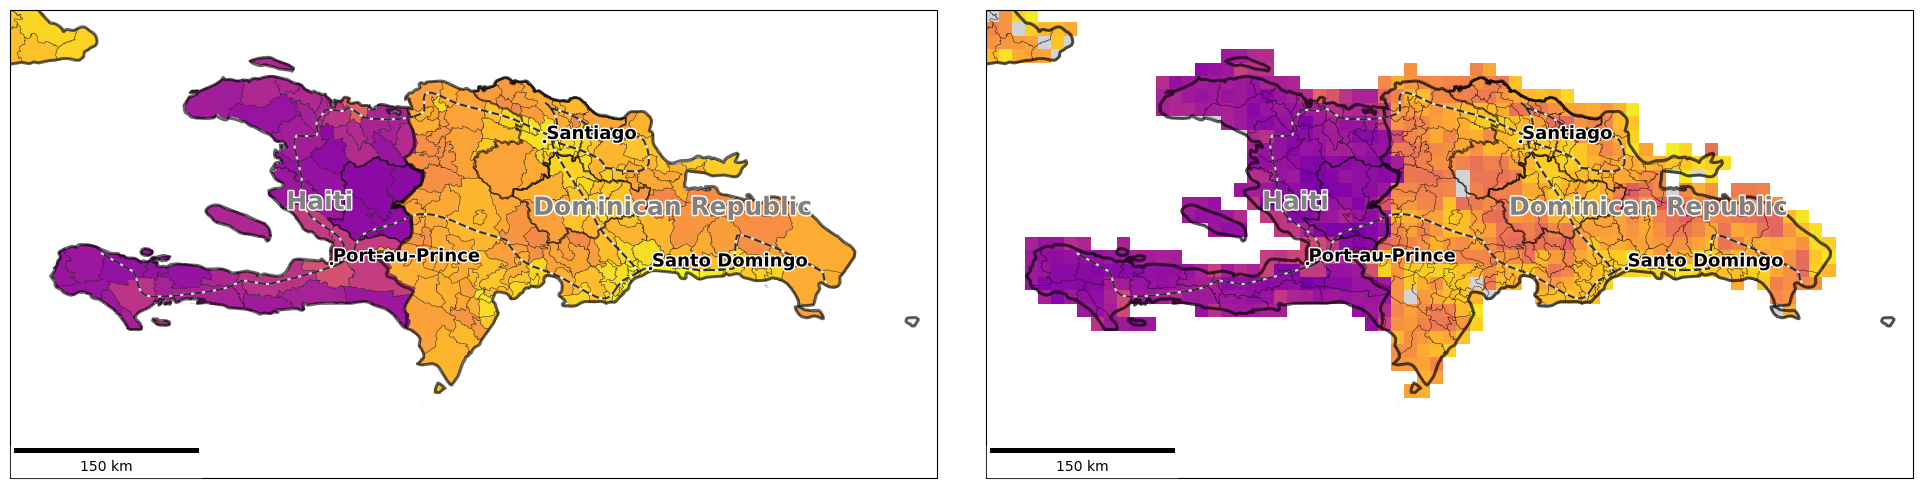

In [48]:
make_superzoom(left_bound, right_bound, top_bound, lower_bound,
              savepath = repo_dir + "figures/" + "superzoom_hispaniola.pdf",
              )

In [49]:
## Bay of bengal

left_bound = 84
right_bound = 102

top_bound = 26
lower_bound = 17

(90, 180)
[[0.59313911 0.58175877 0.5383671  ... 0.61573254 0.59754952 0.60438376]
 [0.62412281 0.63997657 0.58128951 ... 0.63034679 0.67360864 0.60587768]
 [0.60680749 0.66806005 0.60218546 ... 0.65309459 0.71220076 0.6506338 ]
 ...
 [       nan        nan        nan ... 0.8428145  0.86083645 0.80593495]
 [       nan        nan        nan ... 0.75708244 0.83252529 0.80152455]
 [       nan        nan        nan ... 0.75808084 0.80237731 0.75753614]]
Bangladesh
Myanmar


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style

Bangladesh
Myanmar


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style

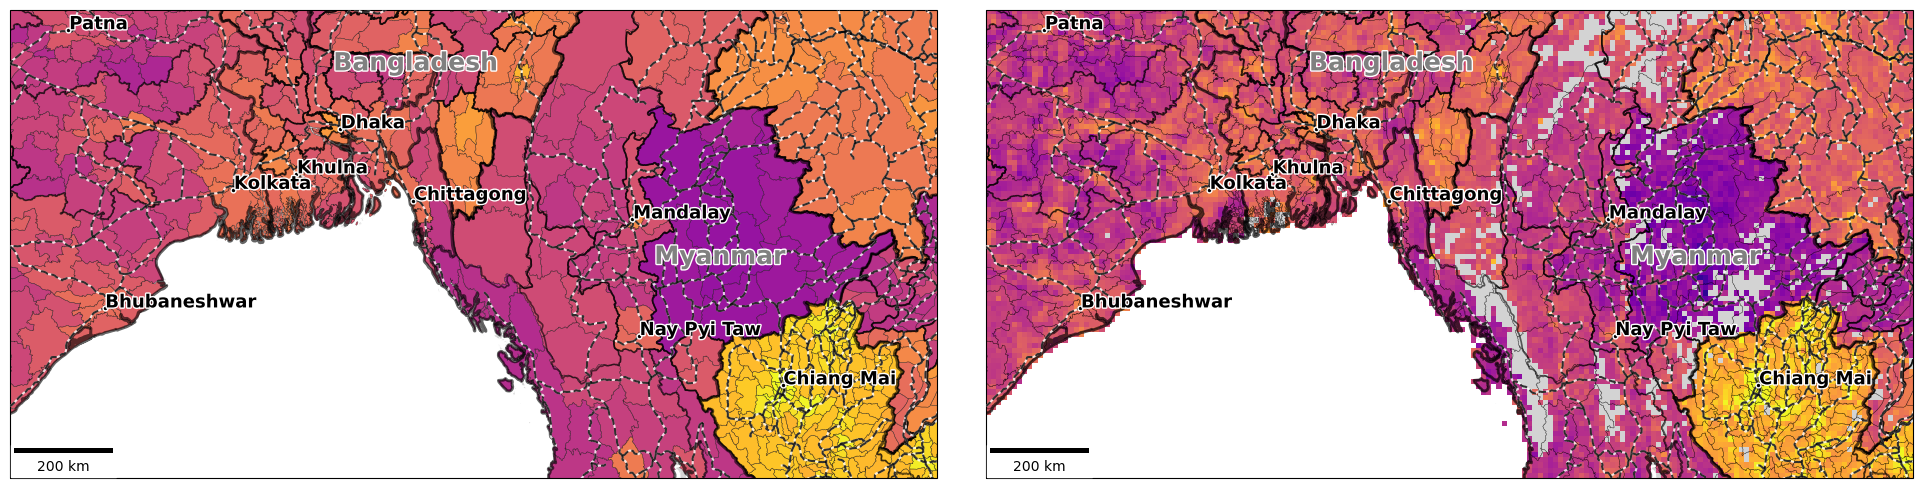

In [50]:
make_superzoom(left_bound, right_bound, top_bound, lower_bound,
              repo_dir + "figures/" + "superzoom_bengal.pdf",
              )

In [51]:
## Gulf of Guinea
left_bound = -4.4
right_bound = 11.8

top_bound = 9.7
lower_bound = 1.6

(81, 162)
[[0.44132925 0.45409482 0.44507878 ... 0.45227122 0.4489056  0.47090666]
 [0.4889003  0.49494003 0.47156947 ... 0.51754908 0.51976268 0.51181166]
 [0.51839214 0.50604007        nan ... 0.52794218 0.48845886 0.47231173]
 ...
 [       nan        nan        nan ... 0.61792466 0.63372707 0.7053654 ]
 [       nan        nan        nan ... 0.64160346 0.64186209 0.64819902]
 [       nan        nan        nan ... 0.70650613 0.64155893        nan]]
Benin
Ghana
Nigeria
Togo


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style

Benin
Ghana
Nigeria
Togo


/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lsherman/miniconda3/envs/hdi/lib/python3.7/site-packages/cartopy/mpl/style

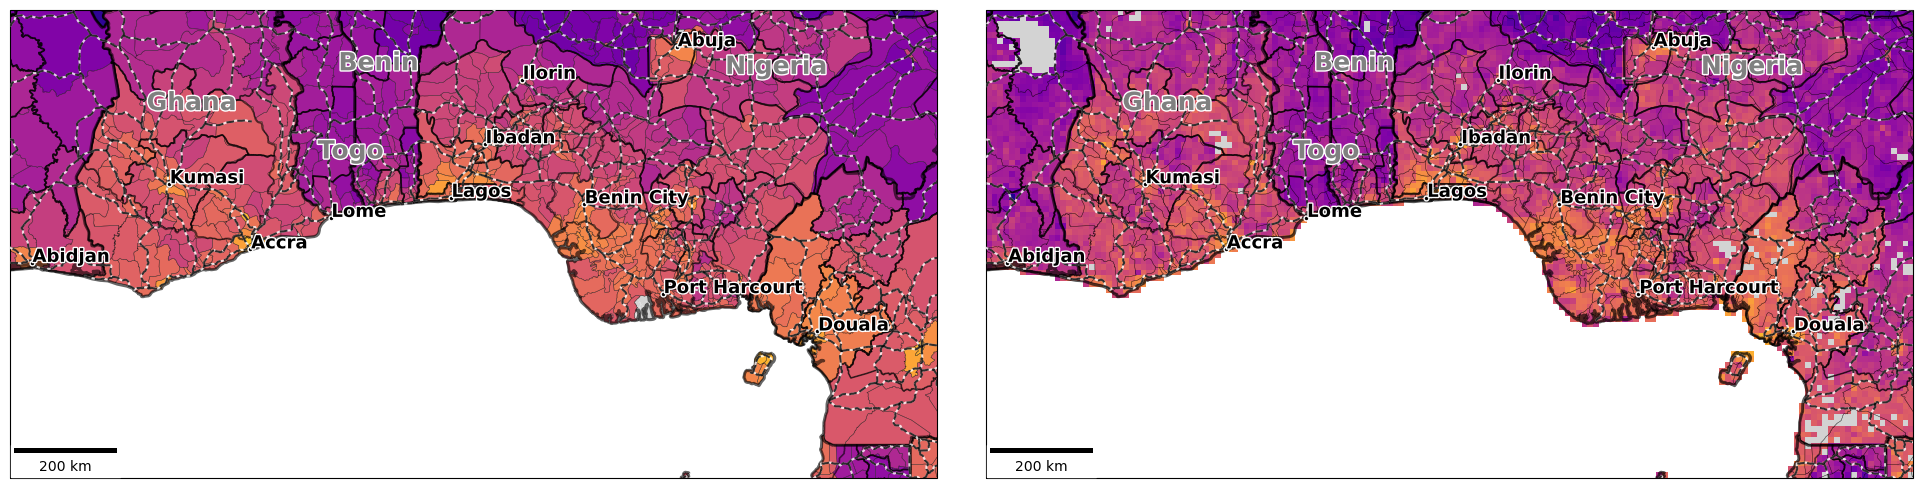

In [52]:
make_superzoom(left_bound, right_bound, top_bound, lower_bound,
               savepath = repo_dir + "figures/" + "superzoom_guinea.pdf",
              )

In [53]:
### Write colorbar

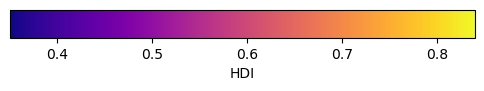

In [54]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.6)

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('HDI')
fig.show()

fig.savefig(repo_dir + "figures/superzoom_cbar.pdf")